In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

#### initialize sim and snapshot

In [3]:
z = 1.
sim = TNGSim('TNG300-3', redshift=z)

In [4]:
# load halo masses
Mhalos = sim.subhalo_mass()

In [5]:
Mhalos

<Quantity [1.8951062e+14, 1.6815611e+14, 2.4272670e+13, ..., 5.6198984e+10,
           5.3226357e+10, 5.8881921e+10] solMass / littleh>

Text(0, 0.5, 'subhalos')

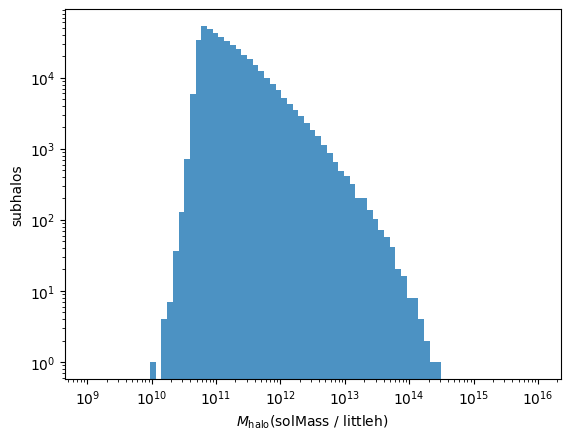

In [6]:
# check out distribution to pick a few cutoffs
fig, ax = plt.subplots()
bins = np.logspace(9, 16, 80)
kwargs = dict(bins=bins, histtype='stepfilled', alpha=0.8)
_, _, _ = ax.hist(Mhalos.value, **kwargs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_\mathrm{halo}$'+f'({Mhalos.unit})')
ax.set_ylabel('subhalos')

In [7]:
Mlims = np.array([5e11, 1e12, 1e13, 1e14]) * Mhalos.unit

In [8]:
halo_groups_idx = [np.where(Mhalos >= Mlim) for Mlim in Mlims]

In [9]:
halo_groups_pos = [sim.subhalo_pos()[idx] for idx in halo_groups_idx]

#### auto and cross correlations

In [10]:
# parameters
randmult = 3
rmin = 1.
rmax = 75.
nbins = 20
nthreads = 12

In [11]:
%%time
# auto
autocorrs = []
for i, halo_pos in enumerate(halo_groups_pos):
    ravg, haloxhalo = corrfunc_ls.compute_3D_ls_auto(halo_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, nrepeats=10)
    autocorrs.append(haloxhalo)

CPU times: user 2min 8s, sys: 194 ms, total: 2min 8s
Wall time: 10.8 s


/work/08811/aew492/ls6/small-scale_cross-corrs/corrfunc_ls.py:61: RuntimeWarning: Mean of empty slice
  return r_avg, np.nanmean(xis, axis=0)


In [12]:
# load dm pos and subsample
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)

In [13]:
%%time
# cross
crosscorrs = []
for i, halo_pos in enumerate(halo_groups_pos):
    ravg, haloxDM = corrfunc_ls.compute_3D_ls_cross(dm_pos.value, halo_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True, boxsize=sim.boxsize.value)
    crosscorrs.append(haloxDM)

CPU times: user 5min 59s, sys: 590 ms, total: 5min 59s
Wall time: 30.8 s


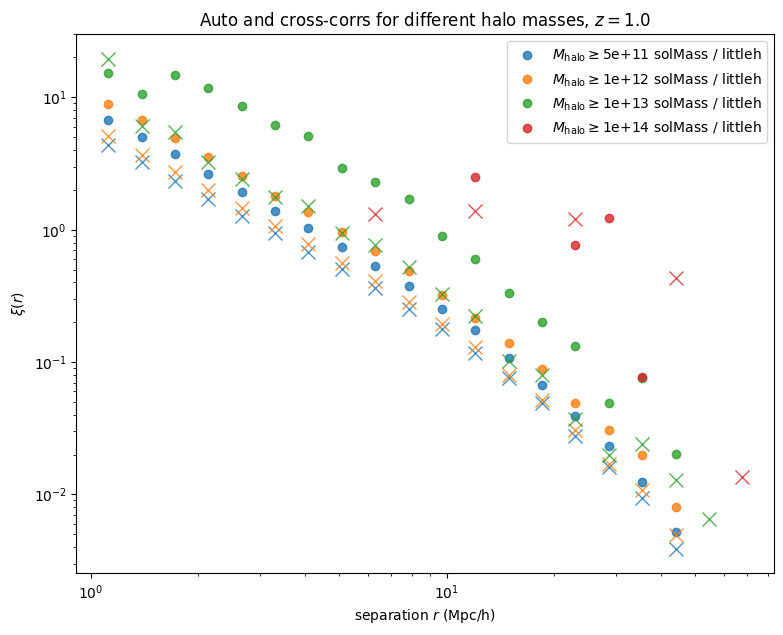

In [15]:
fig, ax = plt.subplots(figsize=(9,7))

kwargs = dict(alpha=0.8, ls='None')

cs = ['C0', 'C1', 'C2', 'C3']
for i, Mlim in enumerate(Mlims):
    ax.plot(ravg, autocorrs[i], color=cs[i], marker='o', ms=6, label='$M_\mathrm{halo}\geq$'+f'{Mlims[i]:.0e}', **kwargs)
    ax.plot(ravg, crosscorrs[i], color=cs[i], marker='x', ms=10, **kwargs)

# ax.axhline(0, color='k', ls='-', alpha=0.3)

# ax.set_ylim(-2,None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(r'Auto and cross-corrs for different halo masses, '+f'$z=${z}')
ax.legend()

In [16]:
# linear theory
xi_lin = tools.linear_2pcf(z, ravg)

In [17]:
# bias
bs_auto = np.divide(np.sqrt(autocorrs), np.sqrt(xi_lin))
bs_cross = np.divide(crosscorrs, xi_lin)

/tmp/ipykernel_188978/4111410500.py:2: RuntimeWarning: invalid value encountered in sqrt
  bs_auto = np.divide(np.sqrt(autocorrs), np.sqrt(xi_lin))


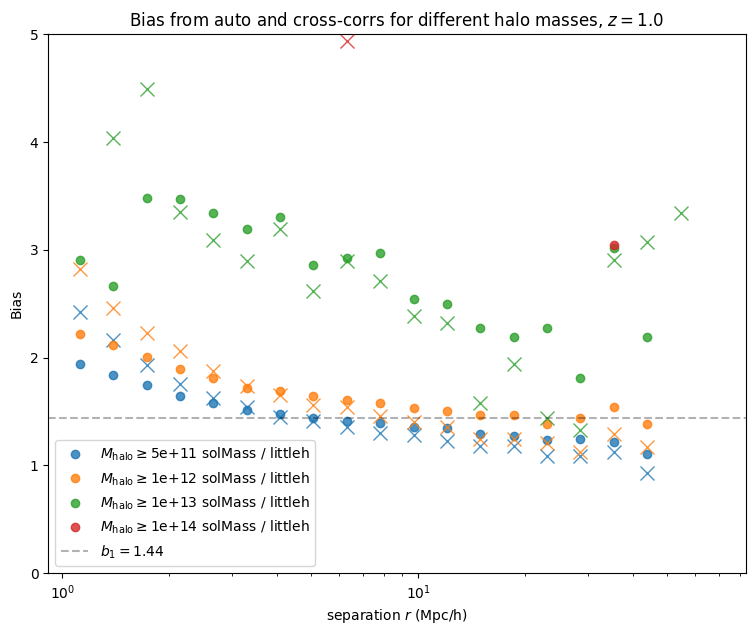

In [19]:
fig, ax = plt.subplots(figsize=(9,7))

kwargs = dict(ls='None', alpha=0.8)

for i, Mlim in enumerate(Mlims):
    ax.plot(ravg, bs_auto[i], marker='o', color=cs[i], label='$M_\mathrm{halo}\geq$'+f'{Mlim:.0e}', **kwargs)
    ax.plot(ravg, bs_cross[i], marker='x', ms=10, color=cs[i], **kwargs)

ax.axhline(1.44, color='k', ls='--', alpha=0.3, label='$b_1=1.44$')

ax.set_ylim(0,5)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(r'Bias from auto and cross-corrs for different halo masses, '+f'$z=${z}')
ax.legend()